In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [2]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None,windows_size=(224,224),stride=(50,50)):
        self.root_dir = root_dir
        self.transform = transform
        self.window_size = windows_size
        self.stride = stride
        
        self.image_dir = os.path.join(root_dir,'images')
        self.mask_dir = os.path.join(root_dir,'1st_manual')
        self.eye_mask_dir = os.path.join(root_dir,'mask')
        
        self.image_filenames = os.listdir(self.image_dir)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_name = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir,image_name)
        image = Image.open(image_path).convert('L')
        patches_image = self.extract_patches(image)
        
        mask_name = image_name.replace("training.tif","manual1.gif")
        mask_path = os.path.join(self.mask_dir,mask_name)
        mask = Image.open(mask_path).convert('L')
        patches_mask = self.extract_patches(mask)
        

        eye_mask_name = image_name.replace(".tif","_mask.gif")
        eye_mask_path = os.path.join(self.eye_mask_dir,eye_mask_name)
        eye_mask = Image.open(eye_mask_path).convert('L')
        patches_eye_mask = self.extract_patches(eye_mask)

        data = []
        if self.transform:
            for patch1,patch2,patch3 in zip(patches_image,patches_mask,patches_eye_mask):
                data.append((self.transform(patch1),self.transform(patch2),self.transform(patch3)))

        return data

    def extract_patches(self, image):
        patches = []
        width, height = image.size
        window_height, window_width = self.window_size
        stride_vertical, stride_horizontal = self.stride

        for y in range(0, height - window_height + 1, stride_vertical):
            for x in range(0, width - window_width + 1, stride_horizontal):
                patch = image.crop((x, y, x + window_width, y + window_height))
                patches.append(patch)

        return patches

transform = transforms.Compose([
    # transforms.Resize((224,224)),
    transforms.ToTensor(),
])

dataset = CustomDataset(root_dir="./training",transform=transform)

In [3]:
dataloader = DataLoader(dataset,batch_size=32,shuffle=False)

# Model architecture

In [4]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder = nn.ModuleList([
            DoubleConv(in_channels, 64),
            DoubleConv(64, 128),
            DoubleConv(128, 256),
            DoubleConv(256, 512),
            DoubleConv(512, 1024)
        ])
        
        self.decoder = nn.ModuleList([
            DoubleConv(1024 + 512, 512),  # Adjusted for concatenation
            DoubleConv(512 + 256, 256),   # Adjusted for concatenation
            DoubleConv(256 + 128, 128),   # Adjusted for concatenation
            DoubleConv(128 + 64, 64),     # Adjusted for concatenation
        ])
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        encoder_outputs = []
        for encoder in self.encoder:
            x = encoder(x)
            encoder_outputs.append(x)
            x = nn.MaxPool2d(kernel_size=2)(x)
        x = self.upsample(x)
        # Decoder
        for i, (decoder, encoder_output) in enumerate(zip(self.decoder, reversed(encoder_outputs[:-1]))):
            # print(x.shape)
            x = self.upsample(x)
            # print(f"Shape of x after upsampling in decoder {i+1}: {x.shape}")
            x = torch.cat([x, encoder_output], dim=1)
            x = decoder(x)
        
        # Final Convolution
        x = self.final_conv(x)
        x = torch.sigmoid(x)  # Assuming binary segmentation
        return x

    # def upsample(self, x):
    #     return nn.ConvTranspose2d(x.shape[1], x.shape[1], kernel_size=2, stride=2).forward(x).to('cuda')


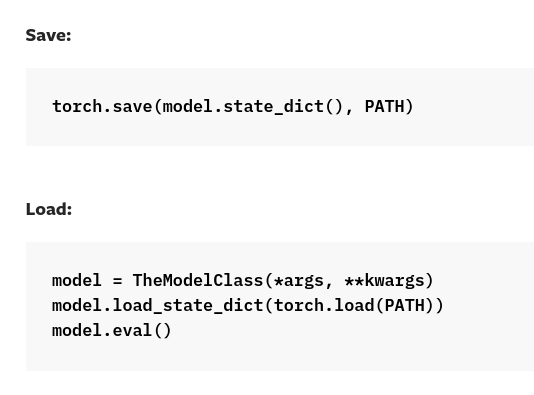

In [5]:
import torch.optim as optim
device = torch.device('cuda')
model = UNet(in_channels=1, out_channels=1).to('cuda')
model = model.to(device)

criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100 
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data in dataloader:
        for images, masks, eye_masks in data:
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            # print("Outputs: ",outputs[0][0][1])
            # print("masks: ",masks[0][0][1])
            
            loss = criterion(outputs, masks)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')


Epoch [1/100], Loss: 18.5754
Epoch [2/100], Loss: 11.5182


KeyboardInterrupt: 

In [ ]:
# torch.save(model.state_dict(),"unet_model.pth")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import torch
from torchvision import transforms
from PIL import Image

model.eval()


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


input_image = Image.open('15_test.tif').convert('L')  
input_tensor = transform(input_image).unsqueeze(0) 


with torch.no_grad():
    output = model(input_tensor.cuda())


predicted_mask = (output > 0.5).float()


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title('Input Image')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask.squeeze().cpu().numpy(), cmap='gray')
plt.title('Predicted Mask')

plt.show()


# Resnet

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None,windows_size=(224,224),stride=(50,50)):
        self.root_dir = root_dir
        self.transform = transform
        self.window_size = windows_size
        self.stride = stride
        
        self.image_dir = os.path.join(root_dir,'images')
        self.mask_dir = os.path.join(root_dir,'1st_manual')
        self.eye_mask_dir = os.path.join(root_dir,'mask')
        
        self.image_filenames = os.listdir(self.image_dir)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_name = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir,image_name)
        image = Image.open(image_path).convert('L')
        patches_image = self.extract_patches(image)
        
        mask_name = image_name.replace("training.tif","manual1.gif")
        mask_path = os.path.join(self.mask_dir,mask_name)
        mask = Image.open(mask_path).convert('L')
        patches_mask = self.extract_patches(mask)
        

        eye_mask_name = image_name.replace(".tif","_mask.gif")
        eye_mask_path = os.path.join(self.eye_mask_dir,eye_mask_name)
        eye_mask = Image.open(eye_mask_path).convert('L')
        patches_eye_mask = self.extract_patches(eye_mask)

        data = []
        if self.transform:
            for patch1,patch2,patch3 in zip(patches_image,patches_mask,patches_eye_mask):
                data.append((self.transform(transforms.Resize((224,224))(patch1)),self.transform(transforms.Resize((224,224))(patch2)),self.transform(transforms.Resize((224,224))(patch3))))

        return data

    def extract_patches(self, image):
        patches = []
        width, height = image.size
        window_height, window_width = self.window_size
        stride_vertical, stride_horizontal = self.stride

        for y in range(0, height - window_height + 1, stride_vertical):
            for x in range(0, width - window_width + 1, stride_horizontal):
                patch = image.crop((x, y, x + window_width, y + window_height))
                patches.append(patch)

        return patches

transform = transforms.Compose([
    # transforms.Resize((224,224)),
    transforms.ToTensor(),
])

dataset = CustomDataset(root_dir="./training",transform=transform)

In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None,windows_size=(224,224),stride=(50,50)):
        self.root_dir = root_dir
        self.transform = transform
        self.window_size = windows_size
        self.stride = stride
        
        self.image_dir = os.path.join(root_dir,'images')
        self.mask_dir = os.path.join(root_dir,'1st_manual')
        self.eye_mask_dir = os.path.join(root_dir,'mask')
        
        self.image_filenames = os.listdir(self.image_dir)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_name = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir,image_name)
        image = Image.open(image_path).convert('L')
        patches_image = self.extract_patches(image)
        
        mask_name = image_name.replace("training.tif","manual1.gif")
        mask_path = os.path.join(self.mask_dir,mask_name)
        mask = Image.open(mask_path).convert('L')
        patches_mask = self.extract_patches(mask)
        

        eye_mask_name = image_name.replace(".tif","_mask.gif")
        eye_mask_path = os.path.join(self.eye_mask_dir,eye_mask_name)
        eye_mask = Image.open(eye_mask_path).convert('L')
        patches_eye_mask = self.extract_patches(eye_mask)

        data = []
        if self.transform:
            for patch1,patch2,patch3 in zip(patches_image,patches_mask,patches_eye_mask):
                data.append((self.transform(patch1),self.transform(patch2),self.transform(patch3)))

        return data

    def extract_patches(self, image):
        patches = []
        width, height = image.size
        window_height, window_width = self.window_size
        stride_vertical, stride_horizontal = self.stride

        for y in range(0, height - window_height + 1, stride_vertical):
            for x in range(0, width - window_width + 1, stride_horizontal):
                patch = image.crop((x, y, x + window_width, y + window_height))
                patches.append(patch)

        return patches

transform = transforms.Compose([
    # transforms.Resize((224,224)),
    transforms.ToTensor(),
])

dataset = CustomDataset(root_dir="./training",transform=transform)

dataloader = DataLoader(dataset,batch_size=32,shuffle=False)

In [2]:
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torchvision import transforms
from PIL import Image

class ResNetGrayScale(nn.Module):
    def __init__(self,pretrained=True):
        super(ResNetGrayScale,self).__init__()

        self.resnet = resnet50(pretrained=pretrained)

        in_channels = 1
        self.resnet.conv1 = nn.Conv2d(in_channels,64,kernel_size=7,stride=2,padding=3,bias=False)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features,224*224)

    def forward(self,x):
        x = self.resnet(x)
        x = x.view(x.size(0),1,224,224)
        return x

model = ResNetGrayScale(pretrained=True).to("cuda")

/home/saikiranbattula/miniconda3/envs/ds677/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/saikiranbattula/miniconda3/envs/ds677/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
import torch.optim as optim
import numpy as np
device = torch.device('cuda')

criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 200 
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data in dataloader:
        for images, masks, eye_masks in data:
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            # print("Outputs: ",outputs[0][0][1])
            # print("masks: ",masks[0][0][1])
            
            loss = criterion(outputs, masks.float())
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [1/200], Loss: 20.9611
Epoch [2/200], Loss: 20.0281
Epoch [3/200], Loss: 19.9352
Epoch [4/200], Loss: 20.1691
Epoch [5/200], Loss: 20.0092
Epoch [6/200], Loss: 19.9108
Epoch [7/200], Loss: 19.9057
Epoch [8/200], Loss: 19.7855
Epoch [9/200], Loss: 19.7880
Epoch [10/200], Loss: 19.7549
Epoch [11/200], Loss: 20.0868
Epoch [12/200], Loss: 19.9695
Epoch [13/200], Loss: 19.9080
Epoch [14/200], Loss: 19.7906
Epoch [15/200], Loss: 19.7384
Epoch [16/200], Loss: 19.6410
Epoch [17/200], Loss: 19.5795
Epoch [18/200], Loss: 19.5354
Epoch [19/200], Loss: 19.4828
Epoch [20/200], Loss: 19.4646
Epoch [21/200], Loss: 19.4282
Epoch [22/200], Loss: 19.3979
Epoch [23/200], Loss: 19.3733
Epoch [24/200], Loss: 19.3807
Epoch [25/200], Loss: 19.3411
Epoch [26/200], Loss: 19.2973
Epoch [27/200], Loss: 19.2803
Epoch [28/200], Loss: 19.2588
Epoch [29/200], Loss: 19.2297
Epoch [30/200], Loss: 19.1808
Epoch [31/200], Loss: 19.1509
Epoch [32/200], Loss: 19.1190
Epoch [33/200], Loss: 19.0676
Epoch [34/200], Los

In [4]:
torch.save(model.state_dict(),"resnet_model.pth")

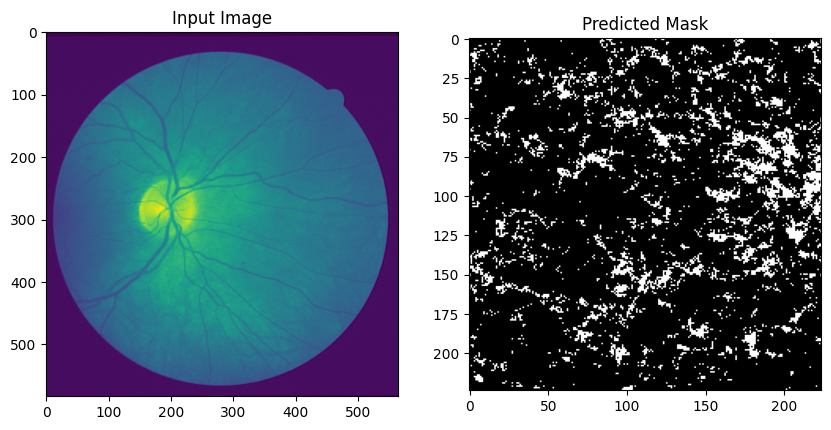

In [6]:
import torch
from torchvision import transforms
from PIL import Image

model.eval()


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


input_image = Image.open('15_test.tif').convert('L')  
input_tensor = transform(input_image).unsqueeze(0) 


with torch.no_grad():
    output = model(input_tensor.cuda())


predicted_mask = (output > 0.5).float()


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title('Input Image')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask.squeeze().cpu().numpy(), cmap='gray')
plt.title('Predicted Mask')

plt.show()